#### IMPORTINMG LIBRARIES

In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### LOADING DATA THROUGH TINGO API

In [2]:
df = pdr.get_data_tiingo("AAPL",api_key="ef3d19916e14333377537aec1f3720c55247836c")

#### CHECKING THE DATA

In [3]:
df.head()

close    high     low     open    volume  \
symbol date                                                                   
AAPL   2016-08-22 00:00:00+00:00  108.51  109.10  107.85  108.860  25820230   
       2016-08-23 00:00:00+00:00  108.85  109.32  108.53  108.590  21257669   
       2016-08-24 00:00:00+00:00  108.03  108.75  107.68  108.565  23675081   
       2016-08-25 00:00:00+00:00  107.57  107.88  106.68  107.390  25086248   
       2016-08-26 00:00:00+00:00  106.94  107.95  106.31  107.410  27766291   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2016-08-22 00:00:00+00:00  25.436673  25.574980  25.281958  25.518720   
       2016-08-23 00:00:00+00:00  25.516376  25.626552  25.441362  25.455427   
       2016-08-24 00:00:00+00:00  25.324153  25.492934  25.242107  25.449566   
       2016-08-25 00:00:00+00:00  25.216321  25.288990  25.007689  25.174126   
       2016-08-26 00:00:00+00:00  25.068638  25.305400  24.920954  25.178814   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2016-08-22 00:00:00+00:00  103280920      0.0          1.0  
       2016-08-23 00:00:00+00:00   85030676      0.0          1.0  
       2016-08-24 00:00:00+00:00   94700324      0.0          1.0  
       2016-08-25 00:00:00+00:00  100344992      0.0          1.0  
       2016-08-26 00:00:00+00:00  111065164      0.0          1.0

In [4]:
df.to_csv("APPL.csv")

In [5]:
df = pd.read_csv("APPL.csv")

In [6]:
df.head(2)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-08-22 00:00:00+00:00,108.51,109.10,107.85,108.86,25820230,25.436673,25.574980,25.281958,25.518720,103280920,0.0,1.0
1,AAPL,2016-08-23 00:00:00+00:00,108.85,109.32,108.53,108.59,21257669,25.516376,25.626552,25.441362,25.455427,85030676,0.0,1.0


* WE WILL BE POREDICTING THE CLOSE PRICE OF THE STOCK

In [7]:
df1 = df['close']

In [8]:
df1.head()

0    108.51
1    108.85
2    108.03
3    107.57
4    106.94
Name: close, dtype: float64

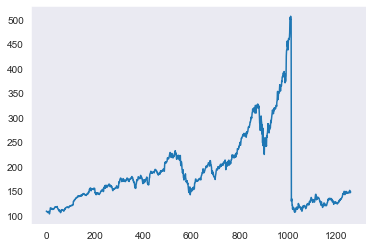

In [9]:
sns.set_style("dark")
plt.plot(df1)
plt.show()

#### LSTM are sensitive to the scale of the data hence we must scale the values (MINMAX scaler)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))

In [12]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1

array([[0.0133512 ],
       [0.01419496],
       [0.01216002],
       ...,
       [0.10728112],
       [0.10812488],
       [0.11182251]])

In [14]:
df1.shape

(1259, 1)

#### TRAIN TEST SPLIT

* AS THIS IS A TIMESERIES PROBLEM STATEMENT WE WILL SPLIT THE DATA IN A DIFFREENT MANNER

In [15]:
train_size = int(len(df1)*0.65)
test_size = len(df1)-train_size

train_data,test_data = df1[:train_size,:1],df1[train_size:,:1]

In [16]:
len(train_data)

818

In [17]:
len(test_data)

441

#### CONVERT AN ARRAY MATRIX TO A DENSE MATRIX USING TIMESTEPS

In [18]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [19]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#### MODELLING USING STACKED LSTM

In [21]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [22]:
print(tf.__version__)

2.0.0


In [23]:
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())

True
True


In [24]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 717 samples, validate on 340 samples
Epoch 1/100
717/717 [==============================] - 7s 9ms/sample - loss: 0.0553 - val_loss: 0.1036
Epoch 2/100
717/717 [==============================] - 0s 412us/sample - loss: 0.0119 - val_loss: 0.0763
Epoch 3/100
717/717 [==============================] - 0s 395us/sample - loss: 0.0061 - val_loss: 0.0797
Epoch 4/100
717/717 [==============================] - 0s 394us/sample - loss: 0.0055 - val_loss: 0.0758
Epoch 5/100
717/717 [==============================] - 0s 392us/sample - loss: 0.0051 - val_loss: 0.0736
Epoch 6/100
717/717 [==============================] - 0s 389us/sample - loss: 0.0047 - val_loss: 0.0688
Epoch 7/100
717/717 [==============================] - 0s 390us/sample - loss: 0.0041 - val_loss: 0.0605
Epoch 8/100
717/717 [==============================] - 0s 387us/sample - loss: 0.0032 - val_loss: 0.0446
Epoch 9/100
717/717 [==============================] - 0s 389us/sample - loss: 0.0020 - val_loss: 0.0382
Epoch 10/10

##### PREDICTION AND PERFORMANCE METRICS

In [27]:
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [28]:
print(train_prediction[:5],'\n\n')
print(test_prediction[:5])

[[0.06145236]
 [0.06173021]
 [0.06202978]
 [0.06234187]
 [0.06265172]] 


[[0.41592282]
 [0.43232816]
 [0.4480591 ]
 [0.46170294]
 [0.47194004]]


* THESE PREDICTION ARE SCALED PREDICTIONS WHICH WE DID EARLIER AS LSTMS ARE SENESITIVE TO BIG VALUES

In [29]:
train_prediction = scaler.inverse_transform(train_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [30]:
print(train_prediction[:5],'\n\n')
print(test_prediction[:5])

[[127.892845]
 [128.0048  ]
 [128.12552 ]
 [128.25128 ]
 [128.37614 ]] 


[[270.7303 ]
 [277.34097]
 [283.6799 ]
 [289.17783]
 [293.30298]]


In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
print("MEAN SQUARED ERROR -- > ",mean_squared_error(test_prediction,ytest))
print("ROOT MEAN SQUARED ERROR -- > ",np.sqrt(mean_squared_error(test_prediction,ytest)))

MEAN SQUARED ERROR -- >  50603.518459929786
ROOT MEAN SQUARED ERROR -- >  224.95225817921852


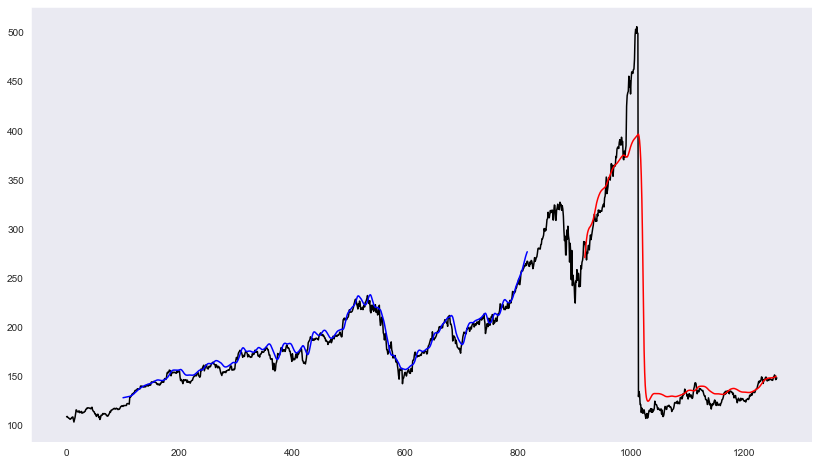

In [71]:
### Plotting 
plt.figure(figsize=(14,8))
sns.set_style("dark")
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_prediction)+look_back, :] = train_prediction
## shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_prediction)+(look_back*2)+1:len(df1)-1, :] = test_prediction
## plot baseline and predictions
plt.plot(scaler.inverse_transform(df1),color='black')
plt.plot(trainPredictPlot,color='blue')
plt.plot(testPredictPlot,color='red')
plt.show()